In [37]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import statsmodels
import statsmodels.api as sm
import scipy as sc
from scipy.stats import binned_statistic_2d, boxcox
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics
import itertools
import statsmodels.formula.api as smf
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

#Только 32битный питон :(
#import mlpy


Populating the interactive namespace from numpy and matplotlib


Читаем заранее подготовленные данные. По строкам время, а по столбцам идентификатор ячейки.

In [2]:
#https://github.com/nlavri/mipt_ya_ml/blob/master/data/stat_pivot_2016-01_2016-06.dat
all_data = pd.read_pickle('TaxiData/stat_pivot_2016-01_2016-06.dat')
print all_data.shape
all_data.head()

(4367, 2500)


,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Получим регионы из примера на каггл

In [3]:
sample = pd.read_csv('TaxiData/sample_solution.csv')
zones = sample.id.str.extract('(\d+)').unique().astype('int')
print zones

c:\python27\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168]


Получим фрейм data с отфильтрованными регионами

In [4]:
data = all_data[zones]
data.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


Нормализуем ряды (колонки)

In [5]:
normData = (data - data.mean()) / data.std()
normData.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.423815,0.139747,-0.594712,0.271886,1.415868,0.980867,1.388771,1.403065,1.870980,1.739070,...,1.560108,-0.911477,-0.639045,-1.089512,-1.258723,-0.820248,-0.708257,-0.869217,-0.833228,0.151241
2016-01-01 01:00:00,0.696681,0.963759,-0.611902,1.714564,2.289706,1.111806,0.440116,0.573737,0.814213,1.171593,...,5.292534,-0.911477,-0.083016,-1.373344,-1.281587,-1.448185,-1.179404,-1.170424,-1.007839,-0.744820
2016-01-01 02:00:00,0.671875,0.164344,-1.058853,1.107120,2.176621,1.148178,0.104257,0.133789,-0.095781,0.036639,...,9.244513,-0.911477,-0.453702,-1.386860,-1.266344,-1.516070,-1.179404,-0.882313,-1.007839,-1.108088
2016-01-01 03:00:00,-0.766873,-0.561279,-1.179186,-0.107767,0.727078,0.959044,0.169072,-0.154453,-0.305457,0.406159,...,9.024959,-0.911477,-0.639045,-1.359828,-1.258723,-1.499099,-1.179404,-1.510920,-1.036940,-1.229177
2016-01-01 04:00:00,-0.965320,-1.102421,-1.282328,-0.335558,-0.372931,-0.095741,-0.184464,-0.033088,-0.343198,0.129019,...,8.366296,-0.911477,-1.009731,-1.380102,-1.289208,-1.516070,-1.179404,-1.445440,-1.007839,-1.301831


In [6]:
dt = normData.transpose()
dt.head()


tpep_pickup_datetime,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,...,2016-06-30 13:00:00,2016-06-30 14:00:00,2016-06-30 15:00:00,2016-06-30 16:00:00,2016-06-30 17:00:00,2016-06-30 18:00:00,2016-06-30 19:00:00,2016-06-30 20:00:00,2016-06-30 21:00:00,2016-06-30 22:00:00
1075,0.423815,0.696681,0.671875,-0.766873,-0.965320,-1.287798,-1.387022,-1.337410,-1.114156,-1.014932,...,1.837756,1.143189,0.572651,0.448621,0.473427,0.622263,1.316830,1.019159,2.185040,1.068771
1076,0.139747,0.963759,0.164344,-0.561279,-1.102421,-1.409888,-1.323797,-1.323797,-1.311499,-1.163915,...,1.062148,1.271226,0.816175,0.238136,0.078253,0.496409,0.705486,0.115149,0.361123,0.434915
1077,-0.594712,-0.611902,-1.058853,-1.179186,-1.282328,-1.368280,-1.402661,-1.282328,-1.299518,-1.161995,...,0.574235,0.316379,-0.285285,0.006952,0.264808,0.557044,0.866471,1.107137,1.038375,0.316379
1125,0.271886,1.714564,1.107120,-0.107767,-0.335558,-1.246723,-1.246723,-1.297343,-1.170793,-0.943001,...,0.474367,1.031190,0.297196,0.499677,0.347816,0.221265,1.663943,1.891735,1.739874,1.486772
1126,1.415868,2.289706,2.176621,0.727078,-0.372931,-1.329013,-1.462658,-1.431817,-1.143964,-1.174806,...,0.398103,0.315860,0.326140,-0.023395,0.757919,1.313063,2.197182,1.559794,1.827086,1.395307


Обучать будем на двух месяцах (для уменьшения общего времени расчетов)

In [7]:
dts = dt.loc[:,'2016-03-01 00:00:00':'2016-04-30 23:00:00']
print dts.shape
dts.head()

(102, 1464)


tpep_pickup_datetime,2016-03-01 00:00:00,2016-03-01 01:00:00,2016-03-01 02:00:00,2016-03-01 03:00:00,2016-03-01 04:00:00,2016-03-01 05:00:00,2016-03-01 06:00:00,2016-03-01 07:00:00,2016-03-01 08:00:00,2016-03-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1075,-1.213380,-1.163768,-1.461440,-1.511052,-1.436634,-1.337410,-1.064544,-0.816485,0.423815,0.002113,...,1.862562,2.036204,2.457906,1.961786,2.333876,1.440860,1.093577,0.696681,0.919935,0.721487
1076,-1.360694,-1.446784,-1.459083,-1.545174,-1.434486,-1.348395,-0.868746,0.434915,0.963759,0.828473,...,2.279719,2.046043,1.000655,1.246629,1.111343,0.939161,0.926863,0.275032,-0.438292,-0.180019
1077,-1.110424,-1.247947,-1.454232,-1.437041,-1.419851,-1.230757,-0.268095,1.433755,2.190132,1.021185,...,1.021185,1.072756,0.471092,0.453902,0.677377,1.038375,0.247617,0.402331,0.006952,-0.371237
1125,-0.689900,-1.373274,-1.449204,-1.575755,-1.474514,-1.449204,-0.487419,0.373126,0.955259,0.550297,...,0.626228,0.626228,0.221265,0.778088,1.132430,0.879329,1.031190,1.233671,0.854019,0.499677
1126,-1.061721,-1.267330,-1.627146,-1.699109,-1.555182,-1.359854,-0.794429,-0.434613,0.315860,0.171933,...,1.107454,1.086893,0.850443,1.549514,1.621477,1.683160,1.117735,1.405587,0.367262,1.056052


Рассчитаем матрицу попарных разностей между кластерами. Используем метрику dtw. https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B4%D0%B8%D0%BD%D0%B0%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%B8_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9_%D1%88%D0%BA%D0%B0%D0%BB%D1%8B

In [8]:
%%time
#m = pairwise_distances(dts, metric=mlpy.dtw_std)
#np.save('TaxiData/distances', m)

#Если нет mlpy, то можно прочитать уже посчитанные через Mlpy на Python 2.7 32 bit попарные дистанции
#https://github.com/nlavri/mipt_ya_ml/blob/master/data/distances.npy
m = np.load('TaxiData/distances.npy')

Wall time: 4 ms


Построим дендрограмму и визуально прикинем число кластеров

c:\python27\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


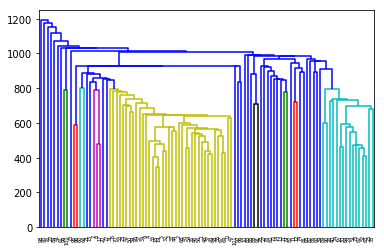

In [40]:
z = linkage(m)
dendrogram(z)
plt.show()

Далее используем агломеративную кластеризацию

In [9]:
agg = AgglomerativeClustering(n_clusters=12, affinity='precomputed', linkage='average')

u = agg.fit_predict(m)
print(u)

[ 0  0  0  0  0  0  0  0  0  0  2  1  1  1  1  0  2  0  0  0  0  0  0  0
  2  2  2  0 11  2  2  0  0  0  0  0  0  0  2  2  2  7  0  0  0  0  0  0
  0  0  0  2  2  0  0  0  0  0  0  0  0  6  2  2  2  2  0  0  0  0  0  1
  1  1  1  2  9  0 10  1  1  1  1  8  5  2  2  2  2  2  2  2  2  4  4  0
  0  0  3  0  4  0]


В каждом кластере найдем медойд - ряд с наименьшим расстоянием от остальных элементов кластера. 
Медойды будут наиболее типичными рядами для каждого кластера.

In [10]:
clusters = {}
for k, v in zip(u, range(len(u))):
    ##print k, v
    if clusters.has_key(k) == False:
        clusters[k] = []
    clusters[k].append(v)

medoids = []    
for c in clusters:
    ixs = clusters[c]
    print 'cluster', c, 'total', len(ixs),
    
    minDist = sys.maxint;
    minDistIx = 0;
    for ix in ixs:
        all_perms = set(itertools.permutations(ixs, 2))
        #print all_perms
        
        other = list(ixs)
        other.remove(ix)
        other_perms = set(itertools.permutations(other, 2))
        #print other_perms
        
        perms = all_perms - other_perms
        #print perms
        
        dist = 0
        for p in perms:
            dist += m[p[0], p[1]]
        dist /= len(ixs)
        
        
        #print minDist
        #print dist
        
        if(dist < minDist):
            minDist = dist
            minDistIx = ix
              
        #print '\r\n'
    print 'medoid', minDistIx, dts.iloc[minDistIx,:].name
    medoids.append(dts.iloc[minDistIx,:].name)
    

cluster 0 total 54 medoid 48 1285
cluster 1 total 12 medoid 71 1387
cluster 2 total 25 medoid 51 1326
cluster 3 total 1 medoid 98 2069
cluster 4 total 3 medoid 100 2119
cluster 5 total 1 medoid 84 1442
cluster 6 total 1 medoid 61 1339
cluster 7 total 1 medoid 41 1278
cluster 8 total 1 medoid 83 1441
cluster 9 total 1 medoid 76 1431
cluster 10 total 1 medoid 78 1435
cluster 11 total 1 medoid 28 1225


[1285, 1387, 1326, 2069, 2119, 1442, 1339, 1278, 1441, 1431, 1435, 1225]


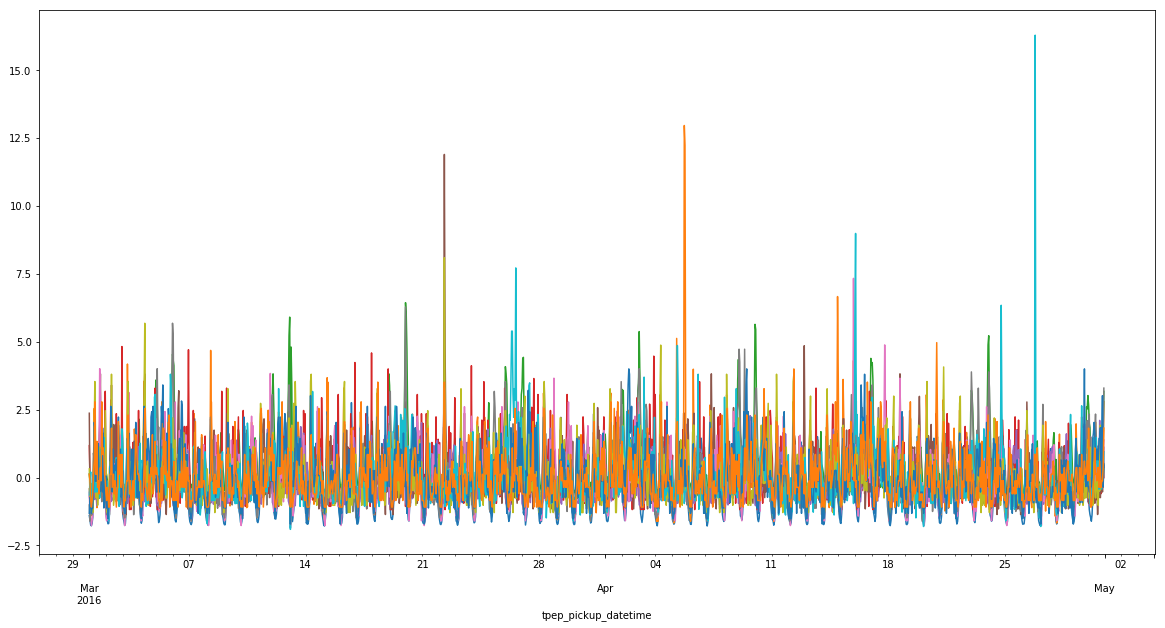

In [11]:
print medoids
figure(figsize=(20,10))
for med in medoids:
    dts.loc[med,:].plot()

Сформируем признаки для регресии рядов

In [11]:
def getDayPart(date_time):
   
    if (date_time.weekday() == 6 or date_time.weekday() == 5):
        if 4 <= date_time.hour and date_time.hour <= 8:
            return 0;
        if 9 <= date_time.hour and date_time.hour <= 18:
            return 1;
        if 19 <= date_time.hour or date_time.hour <= 5:
            return 0;
        
    else:
        if 1 <= date_time.hour and date_time.hour <= 6:
            return 0;
        if 7 <= date_time.hour and date_time.hour <= 18:
            return 1;
        if 19 <= date_time.hour and date_time.hour <= 23:
            return 2;
        if 23 < date_time.hour or date_time.hour == 0:
            return 0;


In [12]:
dfs = []
K = 3
for med in medoids:
    frame = pd.DataFrame()

    frame['data'] = dts.loc[med,:]

    frame['rn'] =  range(1,  frame.shape[0] + 1)
    
    for k in range(1, K + 1):
        frame.loc[:,'s'+ str(k)] = np.sin(frame['rn'] * 2 * np.pi * k / 168)
        frame.loc[:,'c'+ str(k)] = np.cos(frame['rn'] * 2 * np.pi * k / 168)
    
    frame.loc[:, 'day_part'] = frame.index.map(getDayPart)
    #frame['data'].plot()
    plt.show()
    dfs.append(frame)

Выполним регрессию, проведем дифференцирования и изучим остатки. 
Одно сезоннное и одно обычное дифференцирования выглядят достаточными.

0.6137458899363955


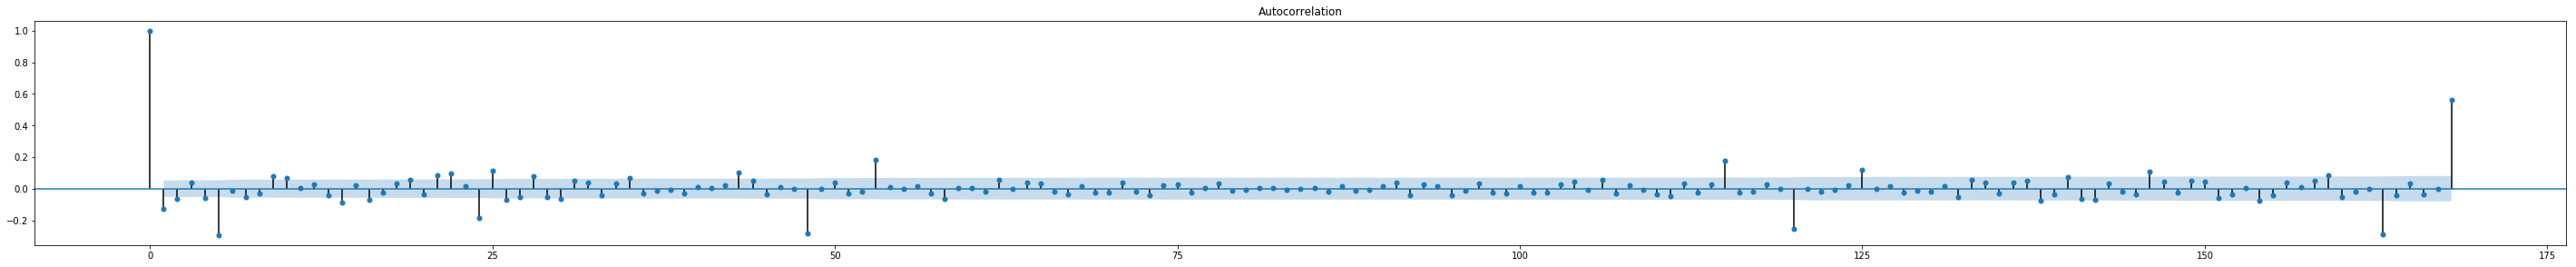

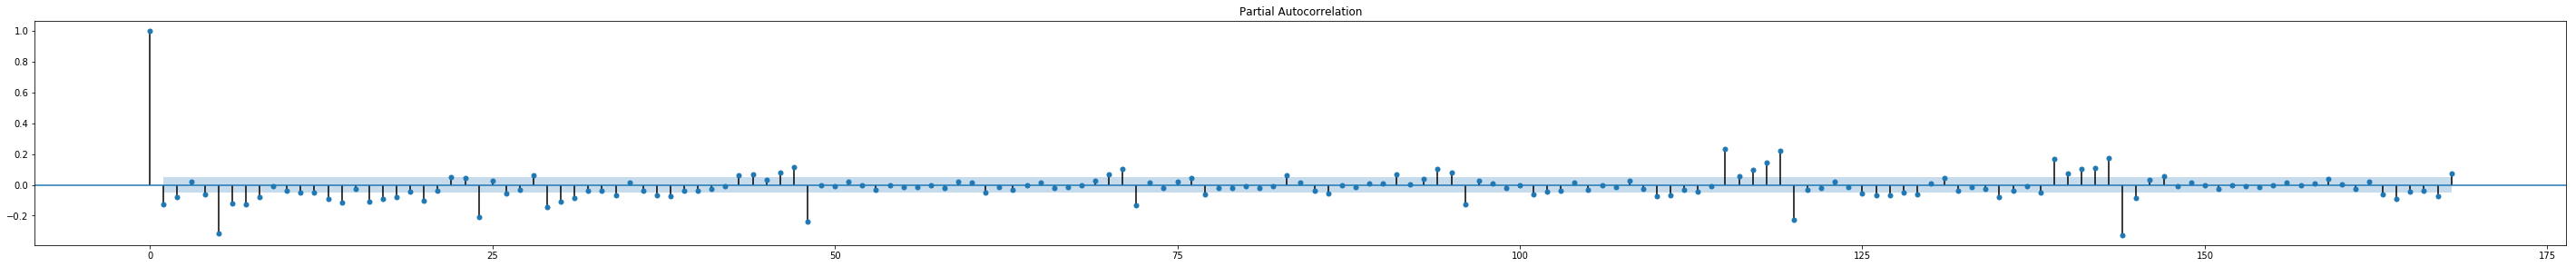

0.6390559851191326


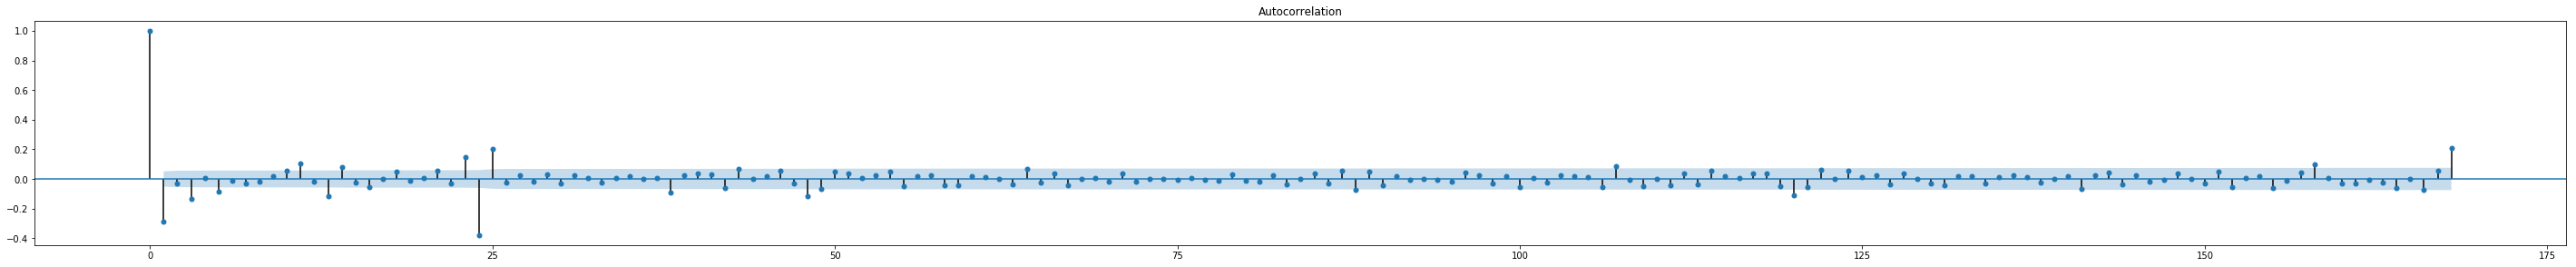

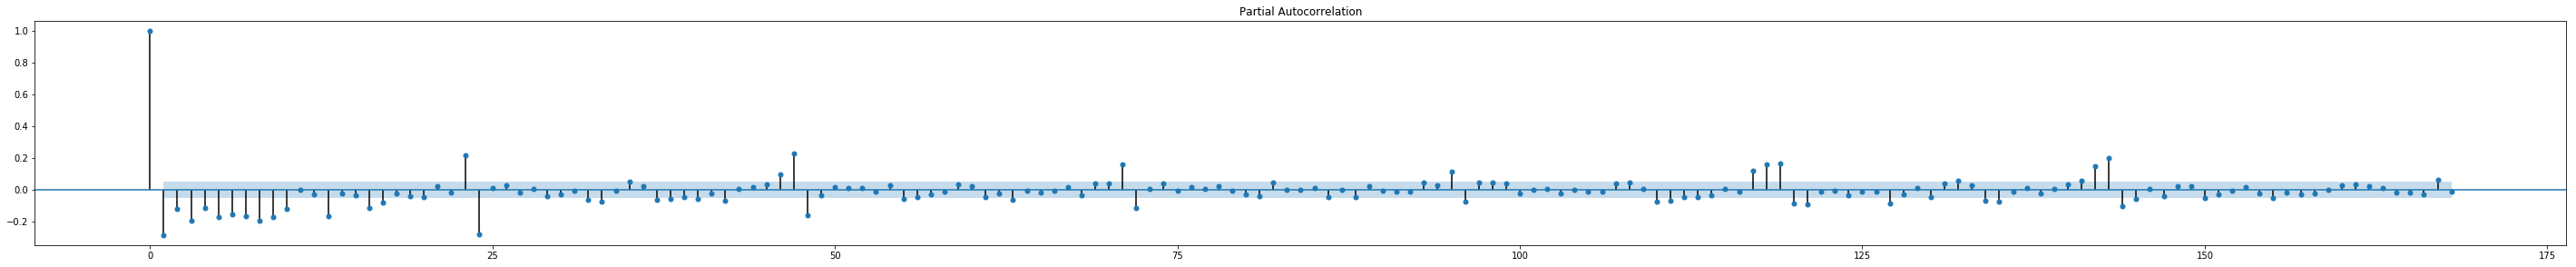

0.6626849844035885


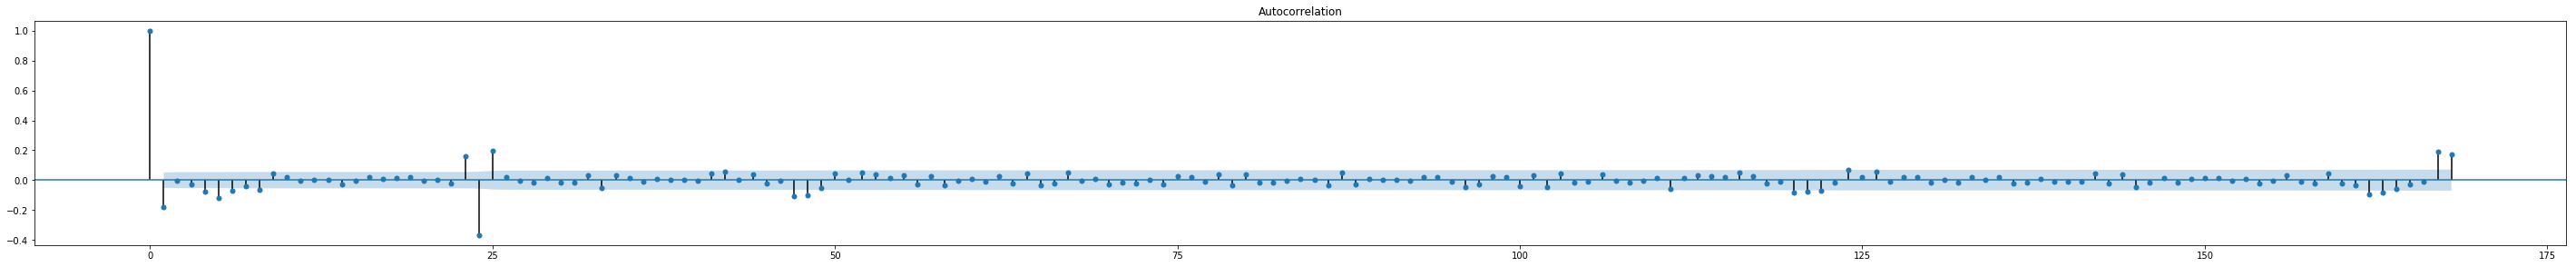

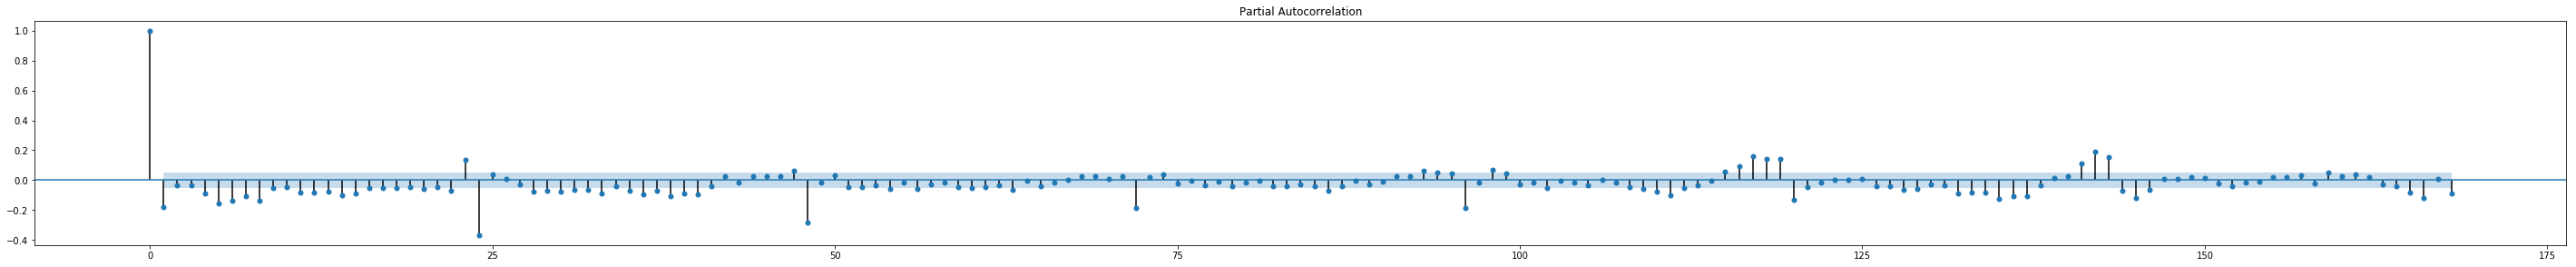

0.6921674657828685


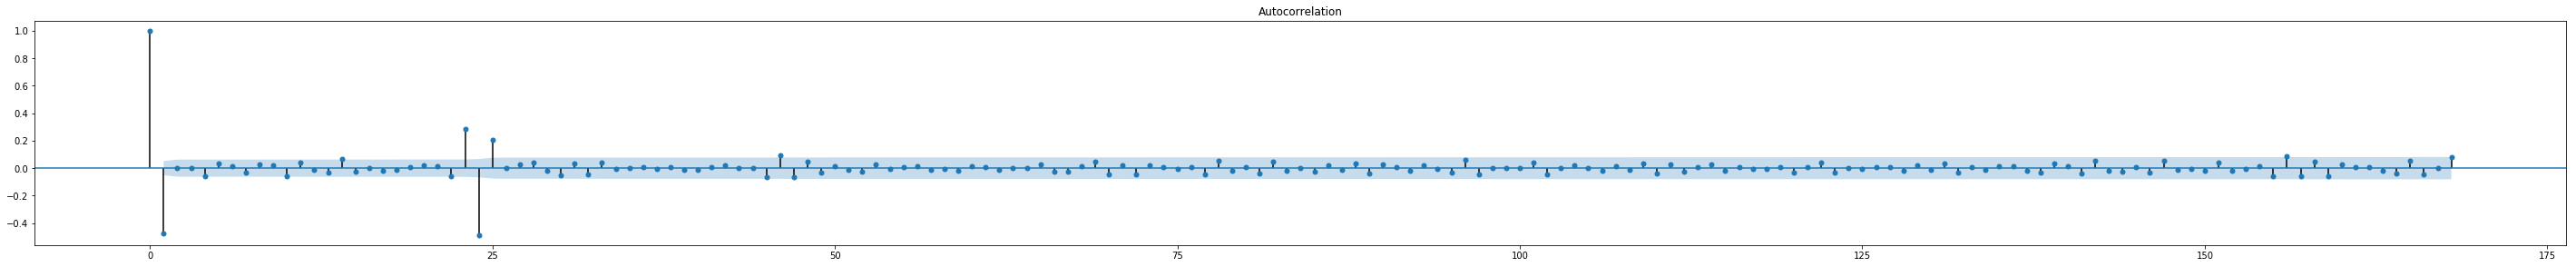

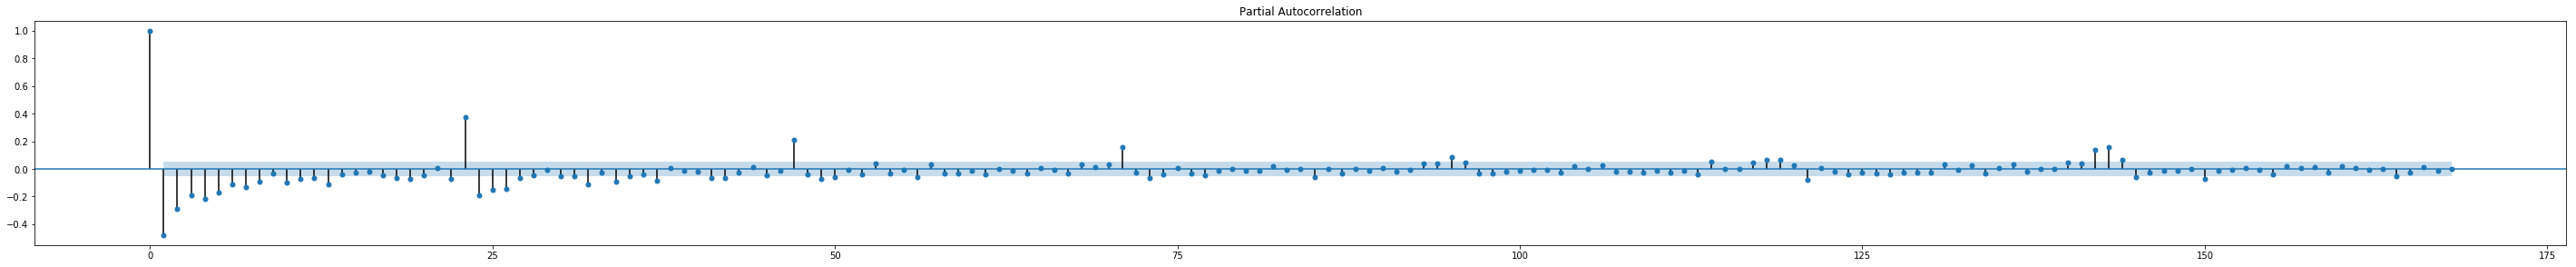

0.4915159361466102


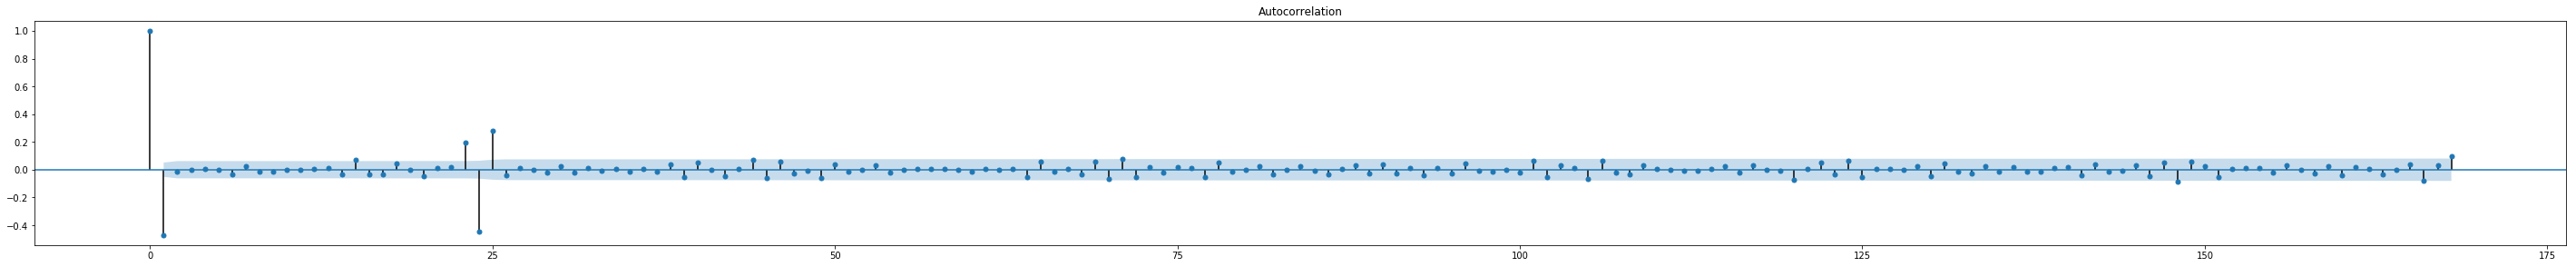

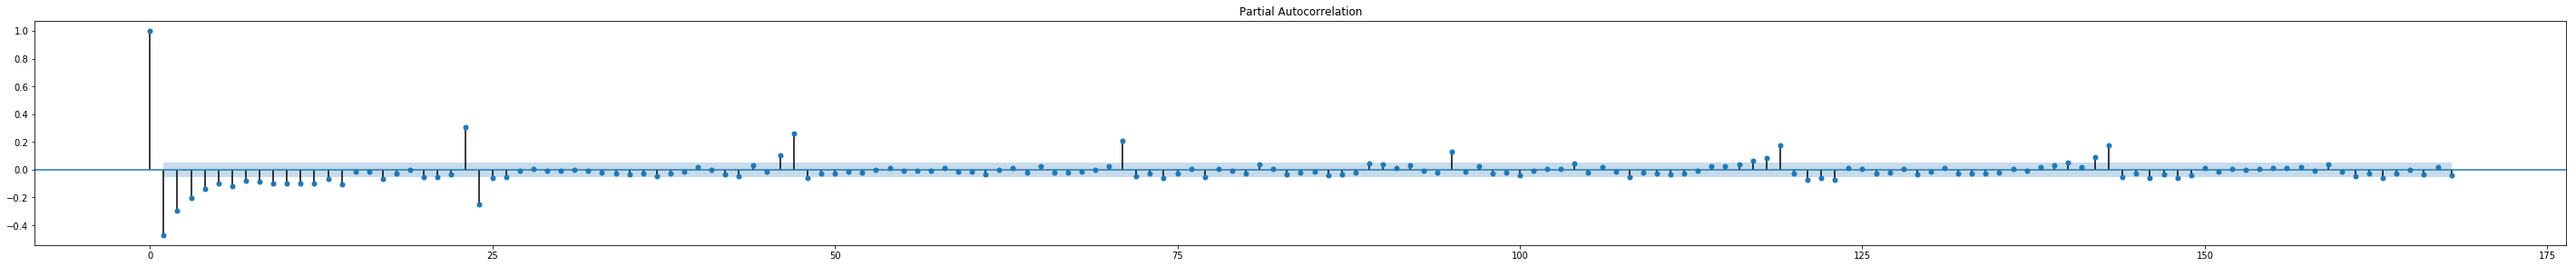

0.6752580696083862


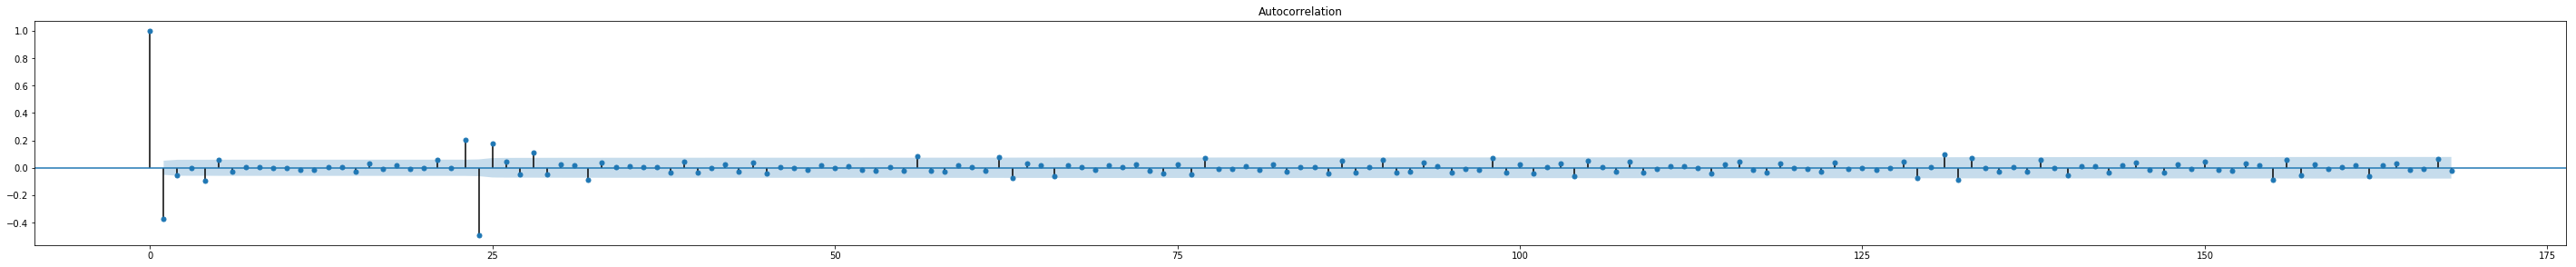

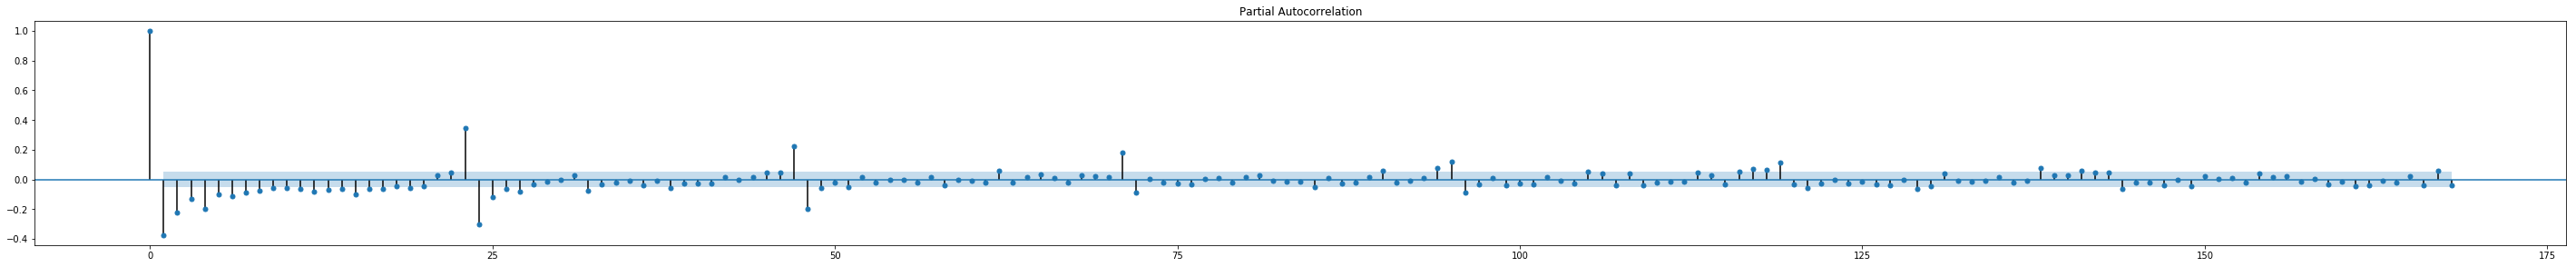

0.6500011128595249


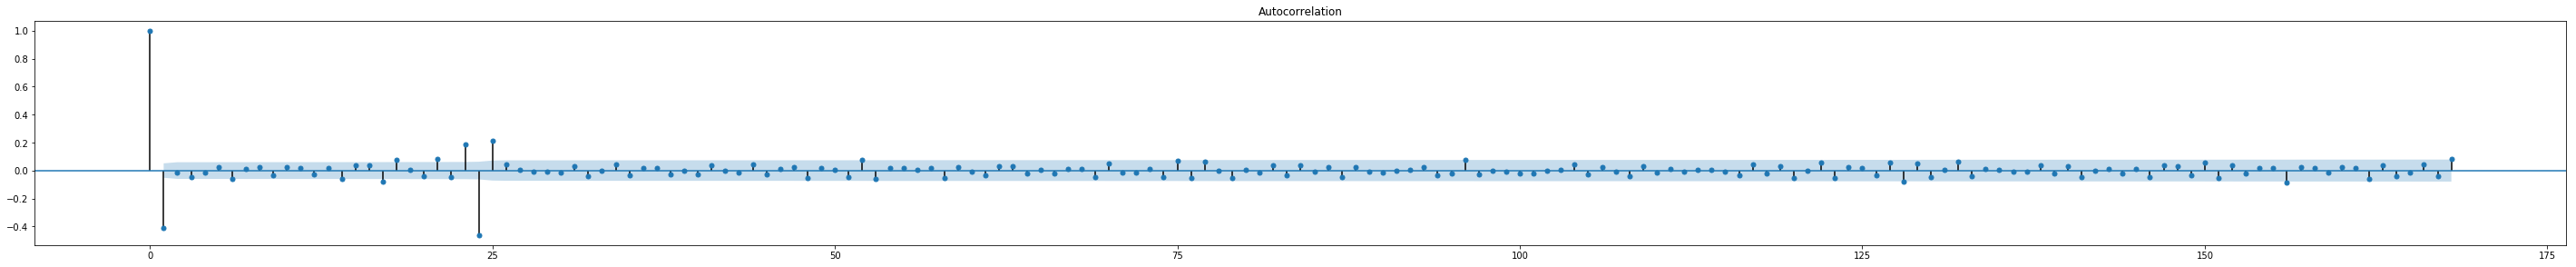

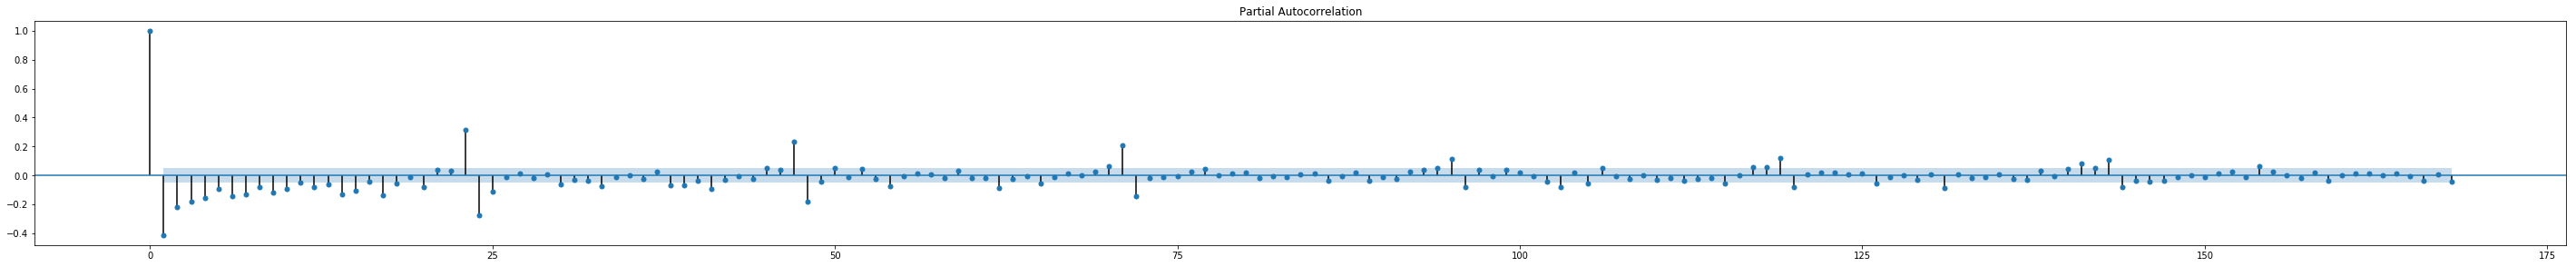

0.6850234616296145


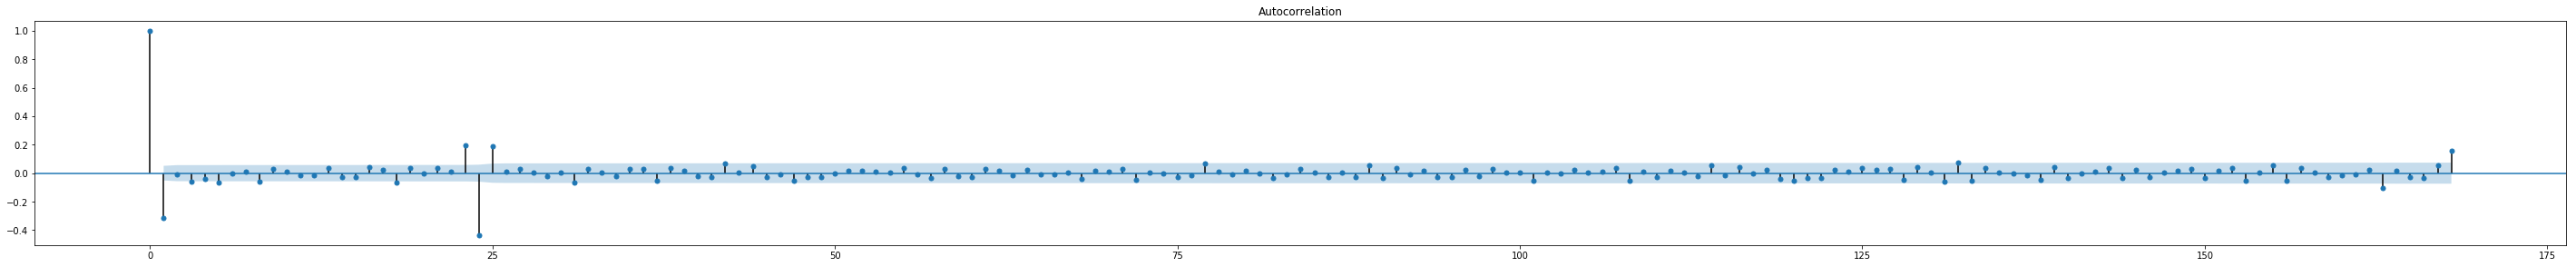

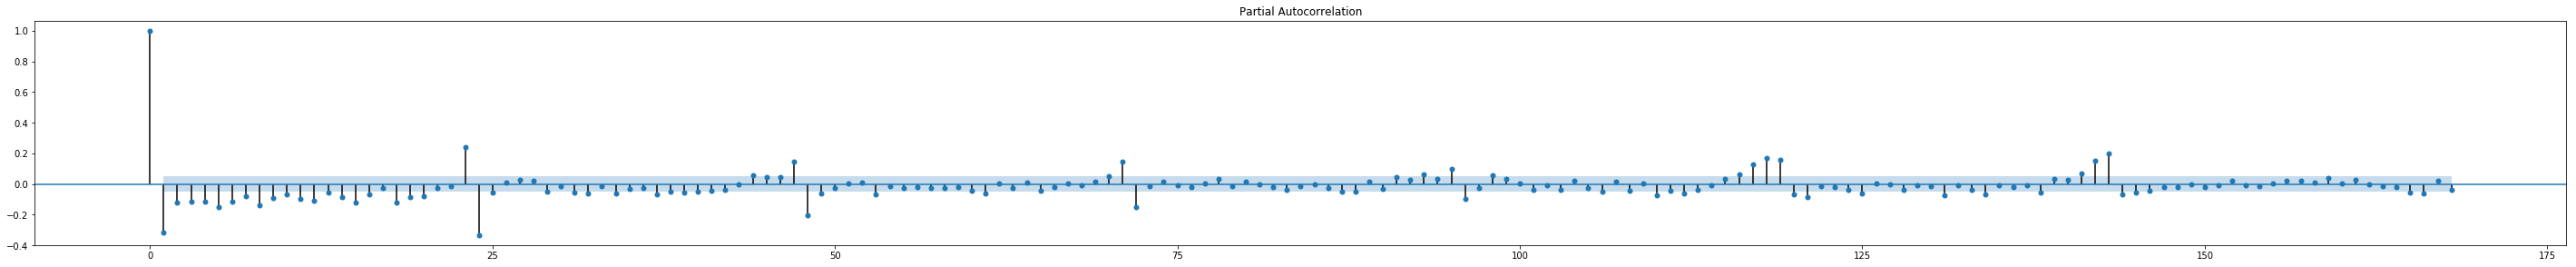

0.718042586678929


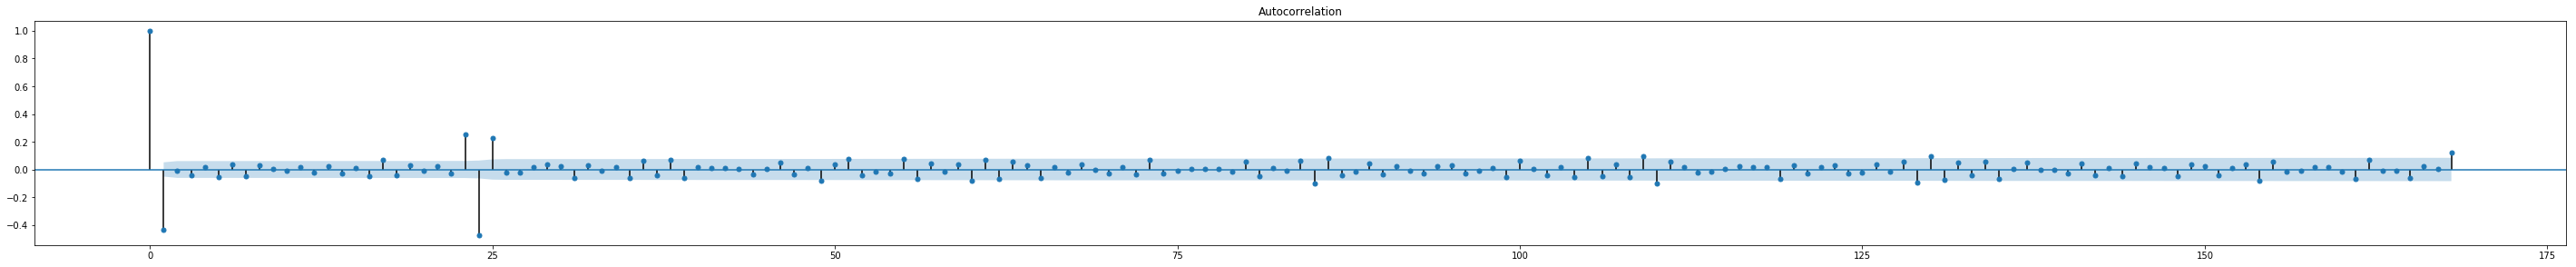

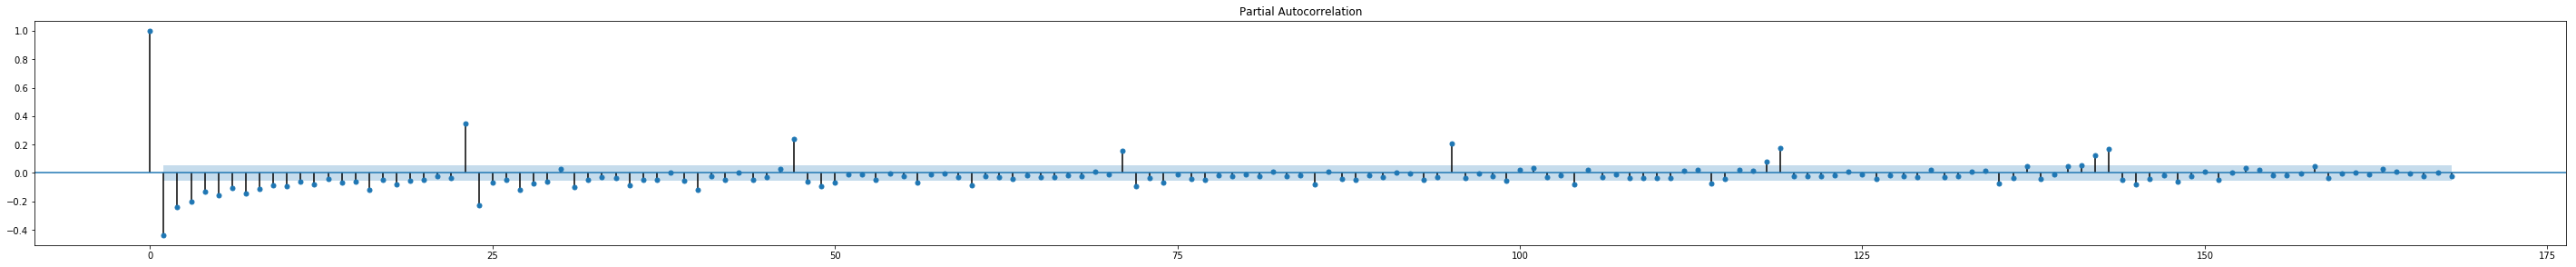

0.5912057325280641


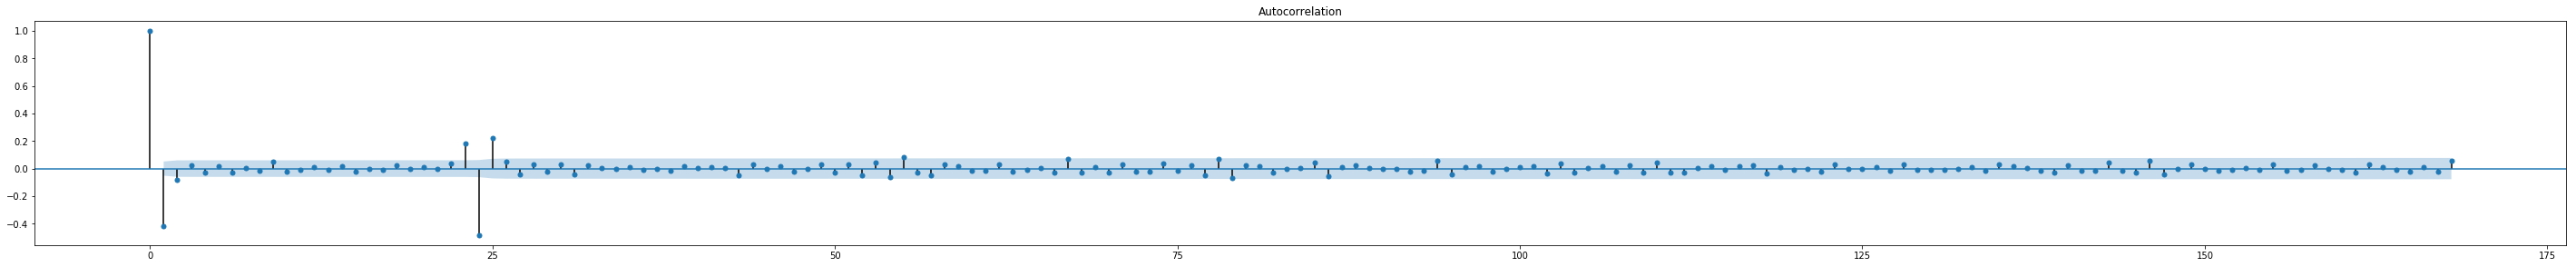

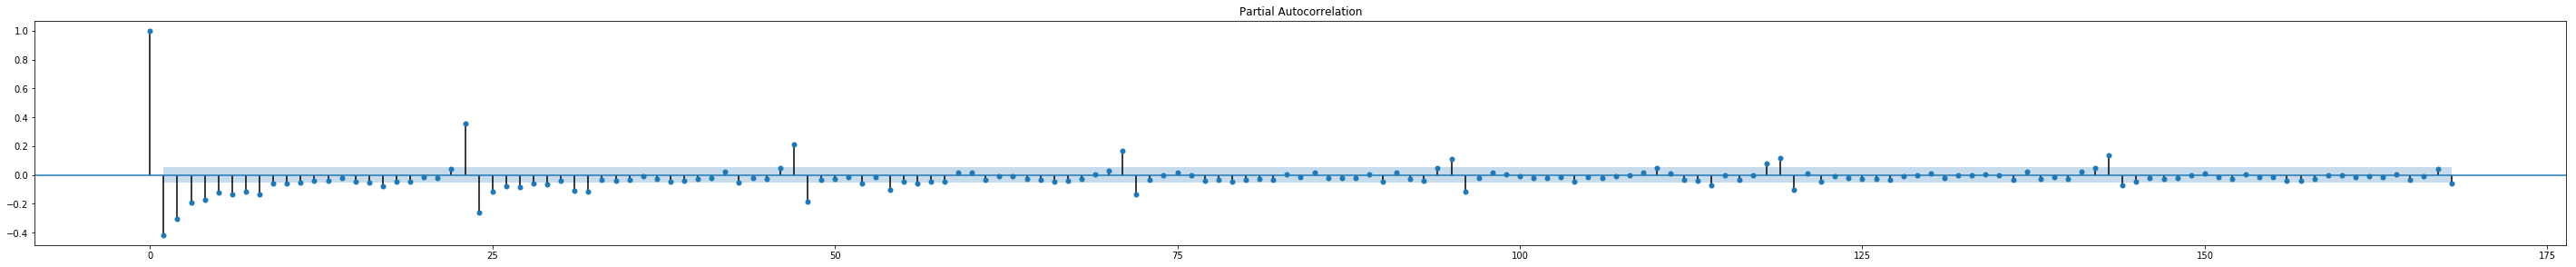

0.6565147888574879


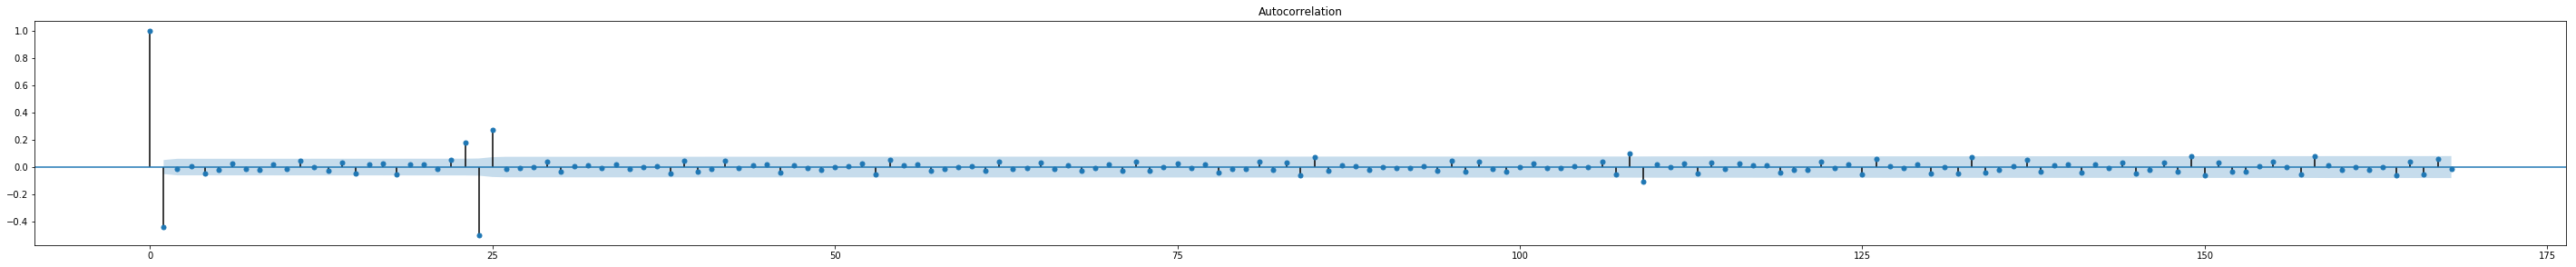

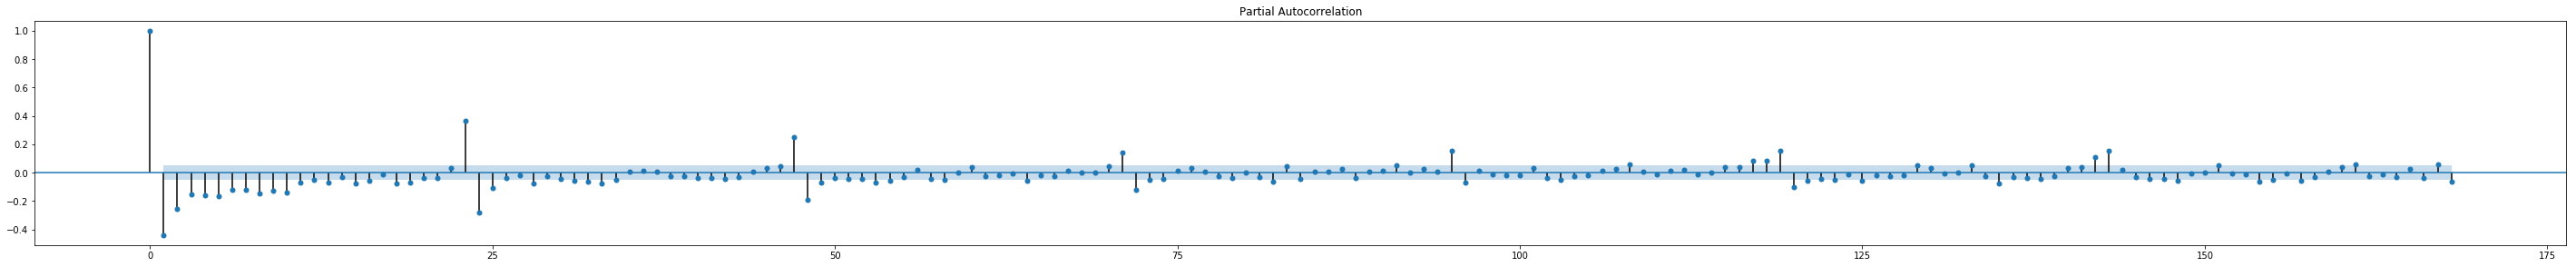

0.6131577862222505


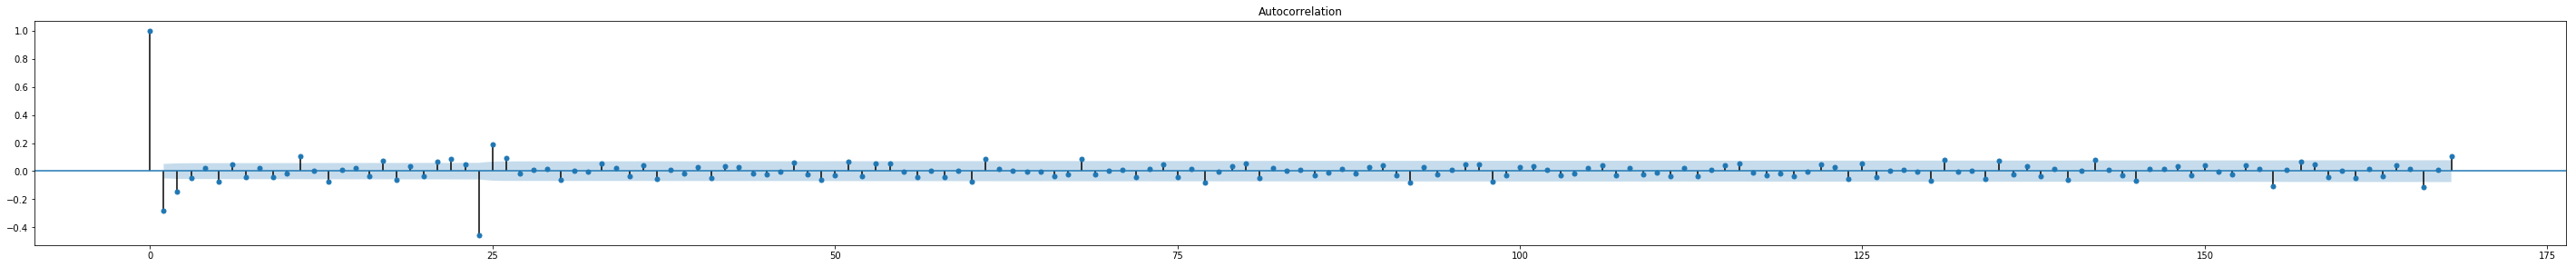

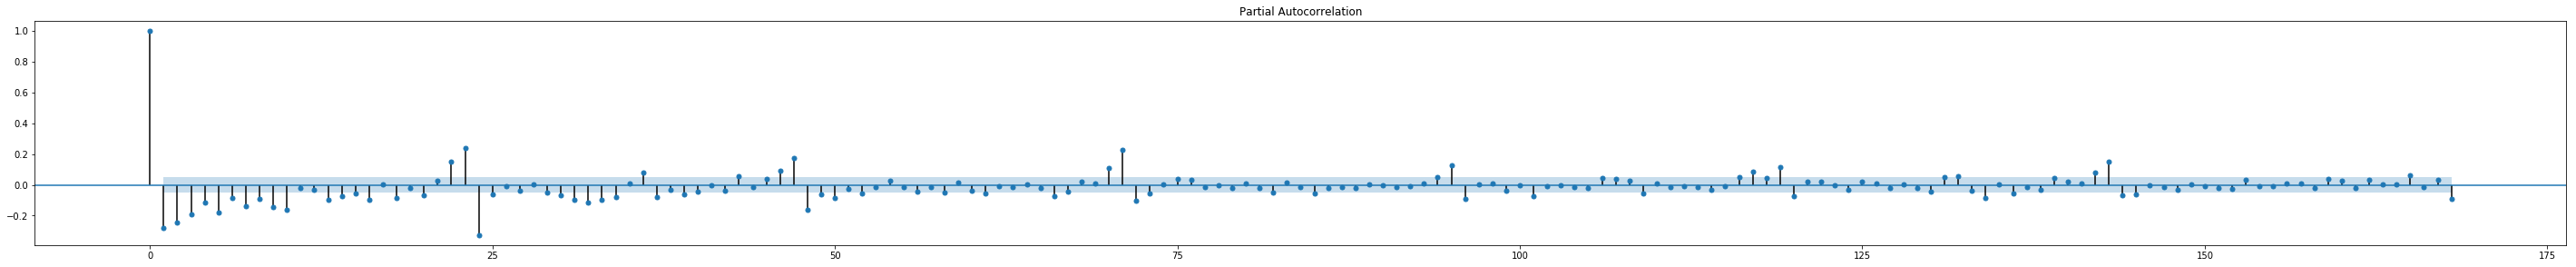

In [13]:
x_names = []
for k in range(1, K + 1):
    x_names.append('s'+ str(k))
    x_names.append('c'+ str(k))

x_names.append('day_part')

for frame in dfs:
    
    m1 = smf.ols('data ~ ' + str.join(' + ', x_names), data=frame)
    fitted = m1.fit()
    plt.rcParams["figure.figsize"] = (18,3)
    
    print metrics.mean_absolute_error(frame['data'], fitted.predict(frame[x_names]))
        
    lag = 24
    frame['resid_diff_24'] = fitted.resid - fitted.resid.shift(lag)
    #dec = sm.tsa.seasonal_decompose(frame['resid_diff_24'][lag:])
    #plt.rcParams["figure.figsize"] = (23,15)
    #dec.plot()
    #dec.trend.plot()
    #pylab.show()
    
    lag2 = 1
    frame['resid_diff_24_1'] = frame['resid_diff_24'] - frame['resid_diff_24'].shift(lag2)
    #dec = sm.tsa.seasonal_decompose(frame['resid_diff_24_1'][(lag + lag2):])
    #plt.rcParams["figure.figsize"] = (23,5)
    #dec.plot()
    #dec.trend.plot()
    #pylab.show()

    plt.figure(figsize(50,10))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(frame['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(frame['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
    pylab.show()


Зададим параметры перебора, исходя из графиков автокорелляций и частичных автокорелляций.

In [14]:
ps = [0, 1, 2, 3, 5]
d =  1
qs = [0, 1, 2, 5, 12]

Ps = [0, 1, 2]
D =  1
Qs = [0, 1, 2]

In [15]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

225


Обучим модели. Будем использовать не все параметры, а только те, которые дали неплохие результаты на предыдущих итерациях обучения, проведенных мною ранее. Полный перебор всех кластеров и 225 параметров не приводится. 

In [19]:
parameters_list = [(0, 12, 2, 1),
                   (0, 12, 2, 1), 
                   (5, 1, 0, 2),
                   (0, 1, 1, 1),
                   (0, 1, 1, 1),
                   (3, 1, 1, 1),
                   (5, 1, 0, 1),
                   (5, 1, 0, 2),
                   (5, 1, 0, 2),
                   (3, 1, 1, 1),
                   (5, 1, 0, 2),
                   (5, 1, 0, 2)
             ]
print len(parameters_list)

12


In [20]:
warnings.filterwarnings('ignore')

cntG = 0
bestModels = {}
results = {}
paramIx = 0
for frame in dfs:
         
    #В разных копиях ноутубка считаем четные и нечетные кластера для ускорения вычислений.
    #if(cntG %2 == 0):
    #    cntG += 1
    #    continue
    
    print 'work on ', frame['data'].name, cntG
    
    best_aic = float("inf")
    cnt = 0
    
    #for param in parameters_list:
    param = parameters_list[paramIx]
    paramIx += 1
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        cnt += 1
        model=sm.tsa.statespace.SARIMAX(frame['data'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], lag),
                                        exog=frame[x_names]
                                       ).fit(disp=-1)
            
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except Exception as e: 
        print cnt, " > ", param, e
        #print('wrong parameters:', param)
        continue
    
    aic = model.aic
    print cnt, " > ", param, aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        bestModels[cntG] = [best_model, best_aic, best_param]
        
    if results.has_key(cntG) == False:
        results[cntG] = []
    results[cntG].append([param, model.aic])
    
    cntG += 1
    
warnings.filterwarnings('default')

work on  data 0
1  >  (0, 12, 2, 1) 330.5471625823028
work on  data 1
1  >  (0, 12, 2, 1) 2525.845628500435
work on  data 2
1  >  (5, 1, 0, 2) 1700.5380623238902
work on  data 3
1  >  (0, 1, 1, 1) 2880.1743722503265
work on  data 4
1  >  (0, 1, 1, 1) 1653.3442201200216
work on  data 5
1  >  (3, 1, 1, 1) 3363.0900398344525
work on  data 6
1  >  (5, 1, 0, 1) 3301.6540331258902
work on  data 7
1  >  (5, 1, 0, 2) 2969.4940022712353
work on  data 8
1  >  (5, 1, 0, 2) 3412.149045639382
work on  data 9
1  >  (3, 1, 1, 1) 3758.622286885496
work on  data 10
1  >  (5, 1, 0, 2) 3054.831094605372
work on  data 11
1  >  (5, 1, 0, 2) 3537.6866851001805


In [21]:
bestModels

{0: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f586588>,
  330.5471625823028,
  (0, 12, 2, 1)],
 1: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x6f5ca20>,
  2525.845628500435,
  (0, 12, 2, 1)],
 2: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f5867f0>,
  1700.5380623238902,
  (5, 1, 0, 2)],
 3: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f586978>,
  2880.1743722503265,
  (0, 1, 1, 1)],
 4: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f586ba8>,
  1653.3442201200216,
  (0, 1, 1, 1)],
 5: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1f586f28>,
  3363.0900398344525,
  (3, 1, 1, 1)],
 6: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x22747278>,
  3301.6540331258902,
  (5, 1, 0, 1)],
 7: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x22747518>,
  2969.4940022712353,
  (5, 1, 0, 2)],
 8: [<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWr

Получим прогнозы на май месяц и вычислим метрику ошибку (пока только сумму разностей по всем отрезкам времени и зонам)

In [107]:
exogDf = pd.DataFrame()
exogDf['data'] = data[medoids[0]]['2016-03-01 00:00:00':]
exogDf['rn'] =  range(1,  exogDf.shape[0] + 1)
    
for k in range(1, K + 1):
    exogDf.loc[:,'s'+ str(k)] = np.sin(exogDf['rn'] * 2 * np.pi * k / 168)
    exogDf.loc[:,'c'+ str(k)] = np.cos(exogDf['rn'] * 2 * np.pi * k / 168)
    
exogDf.loc[:, 'day_part'] = exogDf.index.map(getDayPart)

start_time = pd.to_datetime('2016-04-30 23:00:00')
totalError = 0
for c in clusters:
    print 'cluster ', c
    for ix in clusters[c]:
        seriesName = dts.iloc[ix,:].name
        print '\tzone', seriesName,
        model_fitted = sm.tsa.statespace.SARIMAX(data[seriesName]['2016-03-01 00:00:00':], 
                                         order=(bestModels[c][2][0], d, bestModels[c][2][1]), 
                                         seasonal_order=(bestModels[c][2][2], D, bestModels[c][2][3], lag),
                                         exog=exogDf[x_names]
                                                ).filter(bestModels[c][0].params)
        err_zone = 0
        for ix in range(0, 739):
            from_time = start_time + datetime.timedelta(hours=ix+1)
            to_time = start_time + datetime.timedelta(hours=ix + 6)  
            
            predicted_data = model_fitted.predict(from_time, to_time, dynamic=True)
            
            err =  predicted_data - data[seriesName][from_time:to_time]
            err_sum = err.abs().sum()
            totalError += err_sum
            err_zone += err_sum
        print 'error ', err_zone 

cluster  0
	zone 1075 error  70405.65910201146
	zone 1076 error  111577.23127074252
	zone 1077 error  89851.7774827726
	zone 1125 error  81787.68703486894
	zone 1126 error  155493.48402960988
	zone 1127 error  252209.55818883728
	zone 1128 error  279813.8752054524
	zone 1129 error  383184.0161317145
	zone 1130 error  521261.8554893831
	zone 1131 error  170471.9212170713
	zone 1176 error  31895.424511073274
	zone 1178 error  454116.755086071
	zone 1179 error  349395.67022116703
	zone 1180 error  382535.453389094
	zone 1181 error  537948.446580217
	zone 1182 error  343583.50407976744
	zone 1183 error  128633.03658555842
	zone 1184 error  26042.967889155243
	zone 1224 error  36193.49129646641
	zone 1229 error  410093.85259762564
	zone 1230 error  569263.5702427678
	zone 1231 error  507161.5033512725
	zone 1232 error  509292.81932494004
	zone 1233 error  397466.02290790016
	zone 1234 error  240651.9729913198
	zone 1235 error  115598.43024010622
	zone 1279 error  35096.015827019895
	zone 12

Посчитаем итоговое значение метрики ошибки за май

In [110]:
Qmay = totalError / (len(zones) * 739 * 6)
print Qmay

 33.04337465998621


Аналогично построим прогноз для июня используя данные уже за три месяца.

In [ ]:
juneResults = []

start_time = pd.to_datetime('2016-05-31 23:00:00')
totalJuneError = 0

#В данных отсутстуют отсчеты за 2016-06-30 23:00:00. Возьмем их равными предыдущему часу.
data.loc[data.index.values[-1] + np.timedelta64(1,'h'),:] = data.loc[data.index.values[-1],:]

exogDf = pd.DataFrame()
exogDf['data'] = data[medoids[0]]['2016-03-01 00:00:00':]
exogDf['rn'] =  range(1,  exogDf.shape[0] + 1)
    
for k in range(1, K + 1):
    exogDf.loc[:,'s'+ str(k)] = np.sin(exogDf['rn'] * 2 * np.pi * k / 168)
    exogDf.loc[:,'c'+ str(k)] = np.cos(exogDf['rn'] * 2 * np.pi * k / 168)
    
exogDf.loc[:, 'day_part'] = exogDf.index.map(getDayPart)


for c in clusters:
    print 'cluster ', c
    for ix in clusters[c]:
        seriesName = dts.iloc[ix,:].name
        print '\tzone', seriesName,
        model_fitted = sm.tsa.statespace.SARIMAX(data[seriesName]['2016-03-01 00:00:00':], 
                                         order=(bestModels[c][2][0], d, bestModels[c][2][1]), 
                                         seasonal_order=(bestModels[c][2][2], D, bestModels[c][2][3], lag),
                                         exog=exogDf[x_names]
                                                ).filter(bestModels[c][0].params)
        err_zone = 0
        for ix in range(0, 715):
            from_time = start_time + datetime.timedelta(hours=ix+1)
            to_time = start_time + datetime.timedelta(hours=ix + 6)  
            
            predicted_data = model_fitted.predict(from_time, to_time, dynamic=True)
            
            historyPoint = start_time + datetime.timedelta(hours=ix)
            pdCnt = 1
            for pred in predicted_data:
                pdId = str.format("{0}_{1}_{2}_{3}",seriesName,historyPoint.date(), historyPoint.hour, pdCnt)
                juneResults.append((pdId, pred))
                
                pdCnt += 1
            
            err =  predicted_data - data[seriesName][from_time:to_time]
            err_sum = err.abs().sum()
            totalJuneError += err_sum
            err_zone += err_sum
        print 'error ', err_zone 

c:\python27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


cluster  0
	zone 1075 error  69717.71893534267
	zone 1076 error  99213.64163617375
	zone 1077 error  80899.1515064089
	zone 1125 error  70136.57787995452
	zone 1126

In [23]:
Qjune = totalJuneError / (len(zones) * 715 * 6)
print Qjune

31.50576641207743


In [26]:
juneDf = pd.DataFrame(juneResults)

In [28]:
juneDf.to_csv('TaxiData/w4_kaggle.csv',index=False)

https://www.kaggle.com/c/yellowtaxi/leaderboard

Nikolai 31.50225
